# Linear Regression - Ⅱ
-미국 보스턴 지역의 집값을 13개의 Feature를 이용하여 예측하는 모델을 만들어 보자

In [1]:
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data_utils


import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt

## [1] Data
-Bostion Housing 데이터셋
-보스턴 지역의 주변 환경에 대한 수치값과 집값 데이터
- Sample수 : 506개
- Feature : 14개 

In [24]:
df_raw = pd.read_csv('./BostonHousing.csv') #csv(comma-separated values)파일 가져오기 

In [25]:
print(df_raw.shape) # Dataset의 크기 확인
df_raw

(506, 14)


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


In [26]:
df_raw.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [27]:
# X값 coulumn
x = df_raw.drop(['medv'],axis=1)

# y값 column
y = df_raw['medv']

print(x.shape)
print(y.shape)

(506, 13)
(506,)


In [28]:
#학습데이터와 테스트데이터를 일정비율로 나누기
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=1234)

#학습 데이터
print("x_train의 크기: ",x_train.shape)
print("y_train의 크기: ",y_train.shape,'\n')

#테스트 데이터 
print("x_test의 크기: ",x_test.shape)
print("y_test의 크기: ",y_test.shape)
print(type(y_train))

x_train의 크기:  (354, 13)
y_train의 크기:  (354,) 

x_test의 크기:  (152, 13)
y_test의 크기:  (152,)
<class 'pandas.core.series.Series'>


In [29]:
#학습 데이터 Scaling
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scale = scaler.transform(x_train)  # x_train_scale은 numpy ndarray 


#테스트 데이터 Scaling
x_test_scale = scaler.transform(x_test)    # x_test_scale은 numpy ndarray 


# Array-->Tensor
x_train_tensor = torch.FloatTensor(x_train_scale)
y_train_tensor = torch.FloatTensor(y_train.values) #판다스 Series이므로 values를 사용해서 numpy ndarray로 가져오기

x_test_tensor = torch.FloatTensor(x_test_scale)
y_test_tensor = torch.FloatTensor(y_test.values)


In [30]:
#학습 데이터 배치화 시키기 
train_data =  data_utils.TensorDataset(x_train_tensor, y_train_tensor)

dataloader =  data_utils.DataLoader(train_data, batch_size=100, shuffle=True, drop_last=True)


#배치화된 데이터 확인
for batch_idx, datas in enumerate(dataloader ):
    
    print(batch_idx)
    print(datas[0].shape)  # x_train 
    print(datas[1].shape) # y_train
    break


0
torch.Size([100, 13])
torch.Size([100])


## [2] Model

In [31]:
#Parameter 정의
input_size = 13
output_size = 1
learning_rate = 0.1
n_epochs = 200

In [32]:
#model 생성
model = torch.nn.Linear(input_size, output_size)

In [35]:
#손실함수 생성
criterion = torch.nn.MSELoss()
#Optimizer 생성
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## [3]Training

In [36]:
## Running the model
train_loss = []
test_loss = []

for epoch in range(n_epochs+1):
    
    for idx, (x_batch, y_batch) in enumerate(dataloader):
        
        #Batch 학습
        model.train()
        optimizer.zero_grad()
        
        y_pred = model(x_batch)
        y_pred = y_pred.reshape(-1)
        
        loss_train = criterion(y_pred, y_batch)
        
        loss_train.backward()
        optimizer.step()

        
        #Validation
        model.eval()
        y_test_pred = model(x_test_tensor)
        
        y_test_pred = y_test_pred.reshape(-1)
        
        loss_test = criterion(y_test_pred, y_test_tensor)
        
        
        
   
    train_loss.append(loss_train.item())
    test_loss.append(loss_test.item())
    print("epoch:{}, Loss_train:{:.2f}, Loss_test:{:.2f}".format( epoch, train_loss[-1], test_loss[-1]))

epoch:0, Loss_train:265.64, Loss_test:158.33
epoch:1, Loss_train:84.96, Loss_test:57.99
epoch:2, Loss_train:49.71, Loss_test:30.11
epoch:3, Loss_train:35.40, Loss_test:23.90
epoch:4, Loss_train:18.66, Loss_test:22.17
epoch:5, Loss_train:27.26, Loss_test:21.61
epoch:6, Loss_train:20.33, Loss_test:21.50
epoch:7, Loss_train:25.37, Loss_test:23.62
epoch:8, Loss_train:28.30, Loss_test:22.70
epoch:9, Loss_train:24.49, Loss_test:23.41
epoch:10, Loss_train:11.09, Loss_test:22.76
epoch:11, Loss_train:25.66, Loss_test:22.87
epoch:12, Loss_train:11.19, Loss_test:23.04
epoch:13, Loss_train:24.42, Loss_test:23.02
epoch:14, Loss_train:29.66, Loss_test:23.11
epoch:15, Loss_train:22.66, Loss_test:24.52
epoch:16, Loss_train:25.48, Loss_test:24.31
epoch:17, Loss_train:27.01, Loss_test:23.98
epoch:18, Loss_train:14.07, Loss_test:23.88
epoch:19, Loss_train:25.48, Loss_test:24.47
epoch:20, Loss_train:19.50, Loss_test:23.97
epoch:21, Loss_train:21.22, Loss_test:26.22
epoch:22, Loss_train:22.63, Loss_test:26

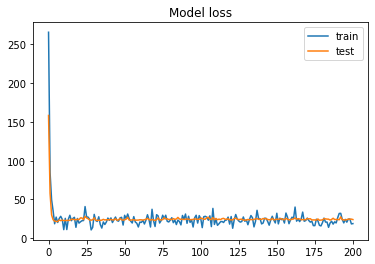

In [37]:
# Loss 값 plot

plt.figure()
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.title('Model loss')
plt.legend(loc= 'upper right')
plt.show()


### <Scaling>

### Tip) Scaling

$$ x_in = \frac{x_io - \mu_i}{\sigma_i} $$

In [129]:
import numpy as np
from sklearn.preprocessing import StandardScaler

data = [[0, 0], [0, 0], [1, 8], [1, 8]]

scaler = StandardScaler()
scaler.fit(data)
data_arr= np.array(data)

print(data_arr.shape)
print(np.mean(data_arr, axis= 0))
data_arr.mean()

(4, 2)
[0.5 4. ]


2.25

In [130]:
data_arr_scaler=scaler.transform(data_arr)
data_arr_scaler

array([[-1., -1.],
       [-1., -1.],
       [ 1.,  1.],
       [ 1.,  1.]])

In [131]:
scaler.transform([[2, 2]])

array([[ 3. , -0.5]])

In [132]:
print(data_arr_scaler)

[[-1. -1.]
 [-1. -1.]
 [ 1.  1.]
 [ 1.  1.]]


In [18]:
np.mean(data_arr_scaler, axis=0)

array([0., 0.])

In [19]:
data_arr_scaler.mean()

0.0

In [20]:
data_arr_scaler.std()

1.0